In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions

In [2]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

# Calculate global, NH and SH CO2 mass from surface to 200000m

In [3]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"

# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

In [4]:
# read co2 mass data, the unit is Gt 
df_co2mass = pd.read_table(IN_PATH+"CT2018_2000_2017_monthly_co2mass.txt", delimiter="\s+")
df_co2mass.columns = ["lon", "lat"] + [d.strftime('%Y-%m-%d') for d in df_datetime["date"]]


In [5]:
# global, NH and SH co2 mass, the unit is Gt 
global_co2mass = df_co2mass.iloc[:,2:].sum(min_count=1)
NH_co2mass = df_co2mass[df_co2mass.lat>0].iloc[:,2:].sum(min_count=1)
SH_co2mass = df_co2mass[df_co2mass.lat<=0].iloc[:,2:].sum(min_count=1)
co2mass_annual = pd.concat([global_co2mass,NH_co2mass,SH_co2mass],axis=1)
co2mass_annual.columns = ["global_co2mas","NH_co2ma","SH_co2ma"]
co2mass_annual["year"] = df_datetime.date.dt.year.tolist()
co2mass_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2mas,2882.531764,2891.443640,2906.711281,2925.762333,2940.636270,2956.527098,2973.240371,2987.623939,3002.352871,3014.258605,3032.137231,3047.705682,3063.996250,3084.754321,3101.016702,3116.801599,3140.581351,3161.182220
NH_co2ma,1441.451265,1445.431192,1452.923211,1462.571300,1470.246132,1478.121368,1487.275066,1493.679590,1501.635838,1507.325180,1516.614113,1524.447109,1533.166157,1543.393557,1551.305150,1559.243212,1571.508378,1582.225024
SH_co2ma,1441.080499,1446.012448,1453.788069,1463.191033,1470.390139,1478.405730,1485.965306,1493.944350,1500.717033,1506.933425,1515.523118,1523.258573,1530.830094,1541.360764,1549.711552,1557.558387,1569.072973,1578.957197


# Plot global, NH and SH CO2 mass from surface to 200000m

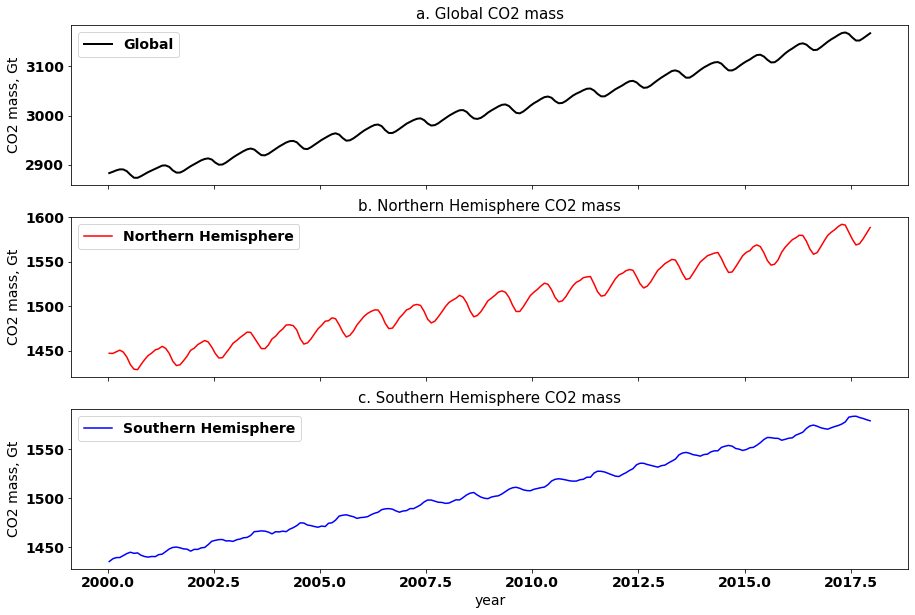

In [6]:
x_decimalyear = df_datetime.decimalyear
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,global_co2mass, 'k', label = "Global", lw=2)
ax1.set_ylabel("CO2 mass, Gt")
ax1.legend()
ax1.set_title("a. Global CO2 mass",fontsize=15)

ax2.plot(x_decimalyear,NH_co2mass, 'r', label = "Northern Hemisphere")
ax2.set_ylabel("CO2 mass, Gt")
ax2.legend()
ax2.set_title("b. Northern Hemisphere CO2 mass",fontsize=15)

ax3.plot(x_decimalyear,SH_co2mass,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2 mass, Gt")
ax3.legend()
ax3.set_title("c. Southern Hemisphere CO2 mass",fontsize=15);

plt.savefig("figure12.png")

# Plot CO2 mass zonal map

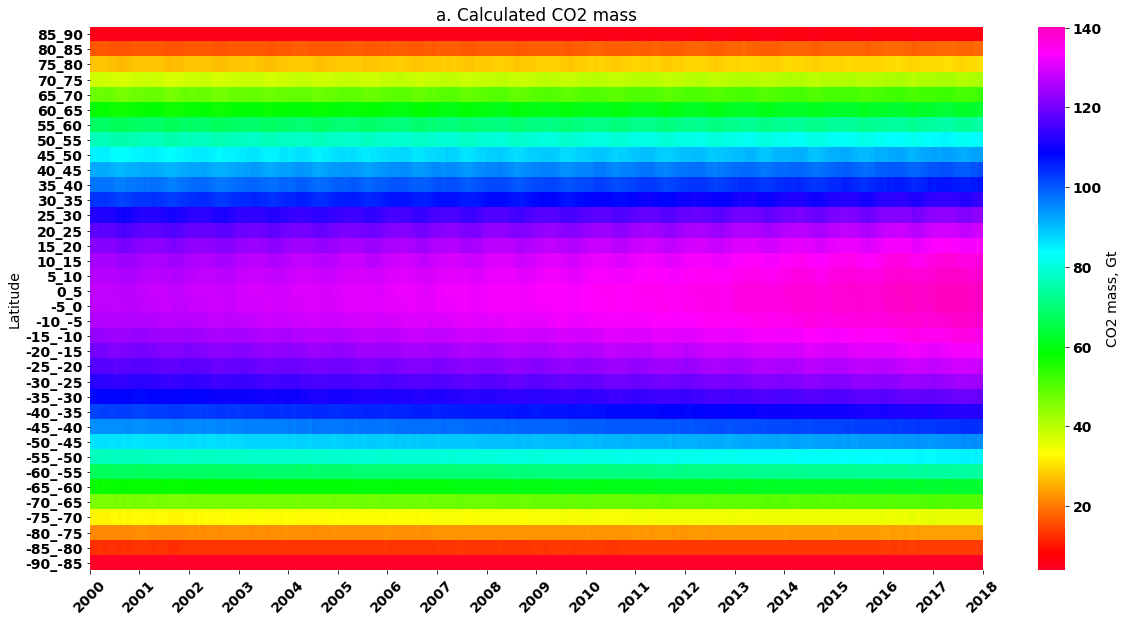

In [7]:
zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2mass.lat) & (df_co2mass.lat<= i+zonal_deg)
    temp_cal = df_co2mass.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,2:].sum()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow"), cbar_kws={'label': 'CO2 mass, Gt'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 mass");

plt.savefig("figure13.png")